In [28]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple

from ihead_data import DataArgs, Dataset, iterate_batches
from ihead_full_model import ModelArgs, Transformer

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
n_layers = 2
n_heads = 2
bos_num = 1
cfg = OmegaConf.load(f"/data/tianyu_guo/birth/gens/model_L{n_layers}_H{n_heads}_lr3-4_bos{bos_num}/params.yaml")
model = Transformer(cfg.model_args)
model.eval()
state_path = f"/data/tianyu_guo/birth/gens/model_L{n_layers}_H{n_heads}_lr3-4_bos{bos_num}/state_4999.pt"
state = torch.load(state_path, map_location="cuda")
model.load_state_dict(state["model_state_dict"], strict=False)


<All keys matched successfully>

In [43]:
ds = Dataset(cfg.data_args, train_test=None)
ds_test = Dataset(cfg.data_args, train_test=None)
ds_test.idxs = ds.idxs
cfg.model_args.vocab_size = ds.num_tokens

In [44]:
x, outs = ds.gen_batch(rng=np.random.default_rng([42, 27]), batch_size=cfg.optim_args.batch_size)
(x, y, outs) = (x[:,:-1], x[:,1:], outs[:,:-1])
x = torch.from_numpy(x)
y = torch.from_numpy(y)
outs = torch.from_numpy(outs)

In [47]:
x[0, :]

tensor([65, 14, 59,  8,  0, 13, 26,  1, 46, 47, 52, 57,  1, 46, 63,  1, 46, 47,
        44, 56, 63,  1, 46, 58, 18, 10,  1, 46, 39, 46, 47, 64, 43, 38, 13, 50,
         6,  1, 46, 39, 46,  1, 46, 47, 56,  1, 46, 39, 46, 43, 38, 13, 58, 18,
        39, 46,  1, 46, 53,  4, 15, 23, 13,  1, 46, 47, 45, 47, 45, 53,  4, 41,
        46, 43, 38, 13, 30, 16, 21,  5, 57,  6,  0,  0, 28, 33, 24, 37, 27, 24,
        13, 25, 21, 10,  1, 46,  1, 46, 58, 18, 47, 56, 43, 38, 17, 31, 43, 38,
        13, 30, 16, 53,  4, 15, 53,  4, 15, 50, 63,  1, 46, 39, 46, 43, 38, 17,
        26, 39, 46, 43, 38, 13, 30, 27, 24, 43, 38, 13, 30, 13, 30, 21, 33, 52,
        42,  1, 46, 43, 38, 13, 10,  0,  0, 31, 15, 39, 46, 39, 46, 43, 38, 17,
        30, 37,  1, 46, 43, 38, 13, 57, 57,  1, 46, 47, 56, 43, 38, 17, 26, 17,
        32, 46, 53,  4, 15, 21, 57,  1, 46, 43, 38, 13, 28, 43, 38, 17, 26, 17,
        26, 31, 43, 38, 13, 52,  1, 46, 53,  4, 41, 50, 39, 46, 39, 46, 43, 38,
        13, 16, 35, 46, 63, 53,  4, 41, 

In [58]:
ds.num_tokens

65

In [62]:
x_tmp = torch.LongTensor(list(range(20,30)) * 5).unsqueeze(0)
x_tmp[0, 0] = 65

In [63]:

scores_list = []
for layer_idx in range(model.n_layers):
    scores_list.append(model.get_layer_scores(x_tmp, layer_idx))
scores = torch.stack(scores_list, dim=1)
scores.shape

torch.Size([1, 2, 2, 50, 50])

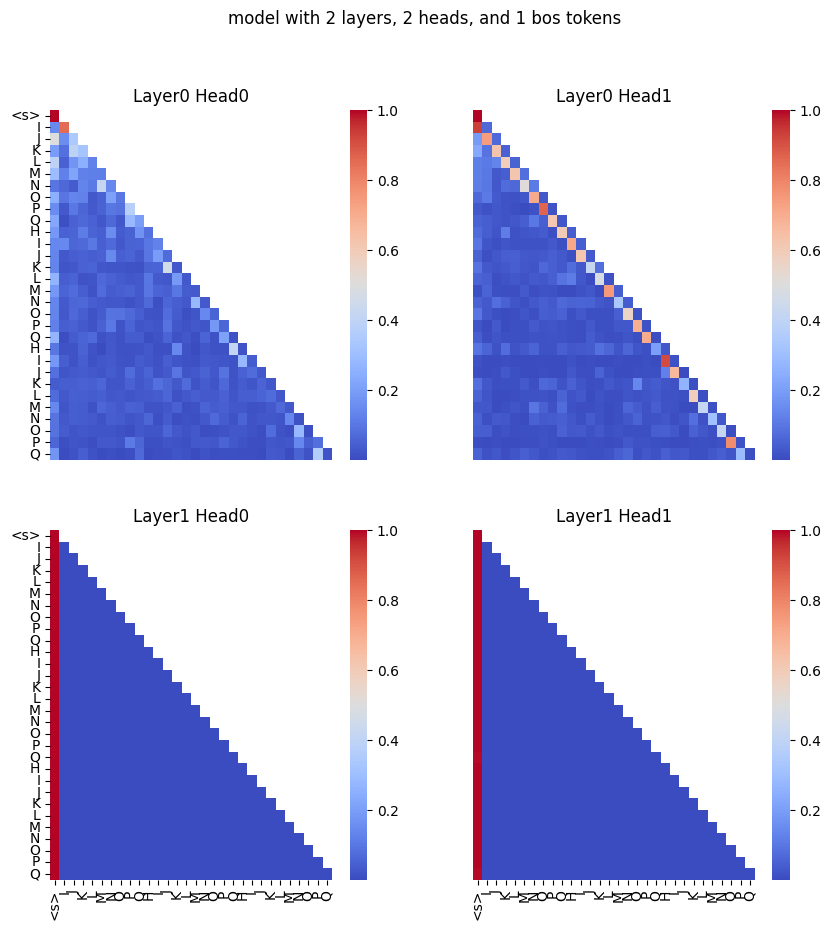

In [64]:
# scores = data['scores'][layer_idx]
seq_len = 30
seq_idx = 0
text = ds.decode(x_tmp[seq_idx, :seq_len].numpy())

fig, axes = plt.subplots(cfg.model_args['n_layers'], cfg.model_args['n_heads'], figsize=(cfg.model_args['n_heads']*5, cfg.model_args['n_layers']*5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    layer_idx = i // cfg.model_args['n_heads']
    head_idx = i % cfg.model_args['n_heads']
    attns = scores[seq_idx, layer_idx, head_idx, :seq_len, :seq_len].detach().numpy()
    # attns = scores[0, i, :20, :20]
    mask = 1 - np.tril(np.ones_like(attns)) # manually impose causal mask for better-looking plots
    if head_idx == 0:
        yticklabels = text
    else:
        yticklabels = False
    if layer_idx == cfg.model_args['n_layers'] - 1:
        xticklabels = text
    else:
        xticklabels = False
    sns.heatmap(
            attns, mask=mask,
            cmap="coolwarm", xticklabels=xticklabels, yticklabels=yticklabels,
            ax=ax,
        )
    ax.set_title(f"Layer{layer_idx} Head{head_idx}")
    # ax.set_xticks(list(ds.decode(x[seq_idx, :20].numpy())))
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

In [34]:
ds.decode(ds.idxs)

['a', 'o', 't', 'e', ' ']

In [35]:
hidden_states_list = []
for layer_idx in range(model.n_layers):
    hidden_states_list.append(model(x, return_layer=layer_idx))
hidden_states = torch.stack(hidden_states_list, dim=1)
hidden_states.shape

torch.Size([512, 4, 256, 256])

Text(0.5, 0.98, 'model with 4 layers, 4 heads, and 1 bos tokens')

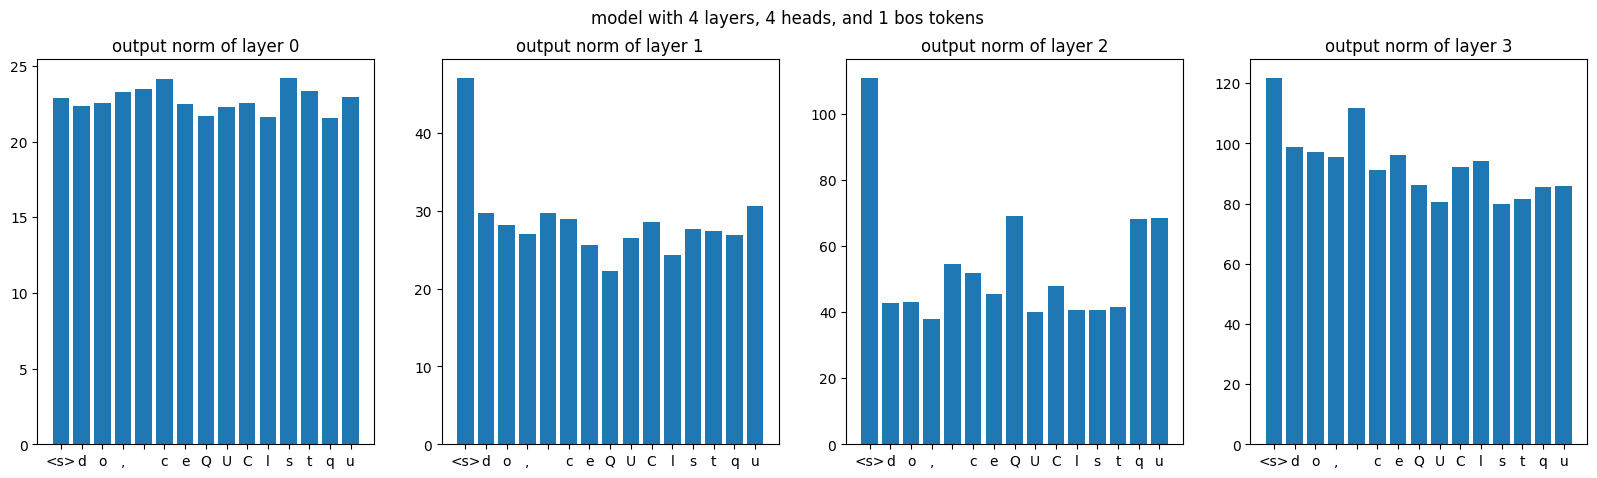

In [36]:
fig, axes = plt.subplots(1, cfg.model_args['n_layers'], figsize=(cfg.model_args['n_layers']*5, 5))
axes = axes.flatten()
for layer_idx in range(cfg.model_args['n_layers']):
    ax = axes[layer_idx]
    ax.bar(text, height=hidden_states[0, layer_idx, :seq_len, :].norm(dim=-1).detach().cpu().numpy())
    ax.set_title(f"output norm of layer {layer_idx}")
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")

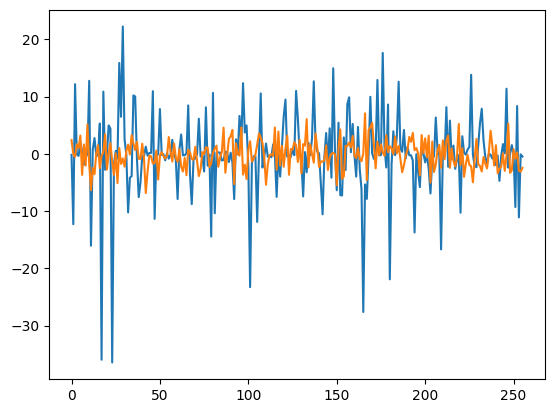

In [41]:
plt.plot(hidden_states[0, 2, 0, :].detach().cpu().numpy())
plt.plot(hidden_states[0, 2, 1, :].detach().cpu().numpy())
